In [1]:
import pandas as pd
import numpy as np
from os import listdir
import sys         

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from pylab import cm
import seaborn as sns
from scipy.stats import sem



ModuleNotFoundError: No module named 'seaborn'

In [2]:
sys.path.append('C:/Users/amilas/Desktop/Python-analysis/functions')    

from my_functions import find_min_distance, create_fig

In [3]:
range_px = 308 
px_size = 0.1625


#specify filepaths to the directories where pooled data is stored
#directories = ['baz_pc//', 'baz_ooplasm//', 'par1_pc//', 'par1_baz_pc//', 'baz_jup_non-pc_PFCs//', 'par1_jup_main_body//', 'par1_jup_pc_long//', 'par1_long//']
directories = ['baz_pc_abl_region//', 'baz_jup_non-pc_PFCs_abl_region//', 'par1_long_abl_region//']

#specify which directories contain data for both channels, and which contain data for only one channel
#one_channel = ['baz_pc//', 'baz_ooplasm//', 'par1_pc//', 'baz_jup_non-pc_PFCs//', 'par1_jup_main_body//', 'par1_long//']
#two_channels = ['par1_baz_pc//', 'par1_jup_pc_long//']

one_channel = ['baz_pc_abl_region//', 'baz_jup_non-pc_PFCs_abl_region//', 'par1_long_abl_region//']
two_channels = []

ablation_borders_channels = ['baz_pc_abl_region//', 'baz_jup_non-pc_PFCs_abl_region//', 'par1_long_abl_region//']


In [4]:
def concatanate_data(df_profile_all, df_profile_norm_all, df_profile, df_distances, range, colname, ablation_borders=False):
    
    reference_coordinates = df_distances[0:1]
    reference_coordinates = [reference_coordinates[i][0] for i in reference_coordinates.columns]
    
    if ablation_borders:
        reference_coordinates_border_1 = df_distances[1:2]
        reference_coordinates_border_1 = [reference_coordinates_border_1[i][1] for i in reference_coordinates_border_1.columns]
        

        reference_coordinates_border_2 = df_distances[2:3]
        reference_coordinates_border_2 = [reference_coordinates_border_2[i][2] for i in reference_coordinates_border_2.columns]
        

        df_distances = df_distances[3:]
        index_border_1 = find_min_distance(df_distances, reference_coordinates_border_1)
        index_border_2 = find_min_distance(df_distances, reference_coordinates_border_2)
        distances_ablation_region = df_distances[index_border_1:index_border_2+1]
        distances_ablation_region = distances_ablation_region.reset_index(drop=True)

        x = np.array(distances_ablation_region.loc[:,0])
        y = np.array(distances_ablation_region.loc[:,1])
        dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2

        ablation_region_width = np.sum(np.sqrt(dist_array)) 
    
        #ablation_region_width = np.linalg.norm([b1-b2 for b1, b2 in zip(reference_coordinates_border_1, reference_coordinates_border_2)])

    else:
        df_distances = df_distances[1:]
        ablation_region_width = None
    
    position_pc = find_min_distance(df_distances, reference_coordinates)
    
    df_profile = df_profile[(position_pc-range):(position_pc+range)]
    df_profile.reset_index(drop=True, inplace=True)
    df_profile_all[colname] = df_profile
    df_profile_norm_all[colname] = (df_profile-min(df_profile))/max(df_profile-min(df_profile))

    if ablation_region_width:
        return df_profile_all, df_profile_norm_all, ablation_region_width
    else: return df_profile_all, df_profile_norm_all

In [5]:


for directory in directories:
    ablation_regions_widths = []
    files = listdir(directory)

    if directory in one_channel:
        increment = 4
        timepoints = [0]
    elif directory in two_channels:
        increment = 6
        timepoints = [3, 0]
    else:
        raise ValueError(f'Unknow directory type for directory {directory}')

    for timepoint in timepoints:
        profile_first_all = pd.DataFrame()
        profile_second_all = pd.DataFrame()
        profile_first_all_normalized = pd.DataFrame()
        profile_second_all_normalized = pd.DataFrame()

        for ind, file in enumerate(files[0::increment]):

            if increment == 6:
                xy_data_first = pd.read_csv(directory+files[ind*increment+timepoint+2], sep='\t', header=None)
                xy_data_second = xy_data_first
                profile_first = pd.read_csv(directory+files[ind*increment+timepoint+1], sep='\t').Mean.dropna()
                profile_first_name = files[ind*increment+timepoint+1][:-4]
                profile_second = pd.read_csv(directory+files[ind*increment+timepoint], sep='\t').Mean.dropna()
                profile_second_name = files[ind*increment+timepoint][:-4]       
            else:
                xy_data_first = pd.read_csv(directory+files[ind*increment+3], sep='\t', header=None)
                xy_data_second = pd.read_csv(directory+files[ind*increment+1], sep='\t', header=None)
                profile_first = pd.read_csv(directory+files[ind*increment+2], sep='\t').Mean.dropna()
                profile_first_name = files[ind*increment+2][:-4]
                profile_second = pd.read_csv(directory+files[ind*increment], sep='\t').Mean.dropna()
                profile_second_name = files[ind*increment][:-4]

            
            if directory in ablation_borders_channels:
                profile_first_all, profile_first_all_normalized = concatanate_data(profile_first_all, profile_first_all_normalized, profile_first, xy_data_first, range_px, profile_first_name)
                profile_second_all, profile_second_all_normalized, ablation_region_width = concatanate_data(profile_second_all, profile_second_all_normalized, profile_second, xy_data_second, range_px, profile_second_name, ablation_borders=True)
                ablation_regions_widths.append(ablation_region_width*px_size)

            else: 
                profile_first_all, profile_first_all_normalized = concatanate_data(profile_first_all, profile_first_all_normalized, profile_first, xy_data_first, range_px, profile_first_name)
                profile_second_all, profile_second_all_normalized = concatanate_data(profile_second_all, profile_second_all_normalized, profile_second, xy_data_second, range_px, profile_second_name)

            
            ## Save results to csv files
            result = pd.concat([profile_first_all_normalized, profile_second_all_normalized], axis=1)

            file_name=directory[:-2]
            if increment==6:
                if timepoint == 0: file_name+='_after'
                else: file_name+= '_before'

            result.to_csv('results/' + file_name + '.csv', index=False)
    
    with open(f'results/{file_name}.txt', 'w') as f:
        f.write(str(np.mean(ablation_regions_widths)))
        f.close()
   



        

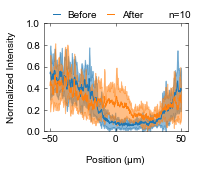

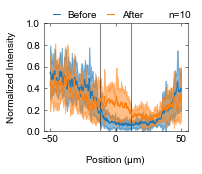

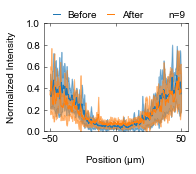

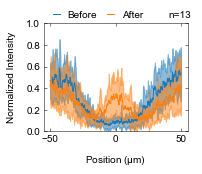

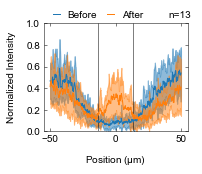

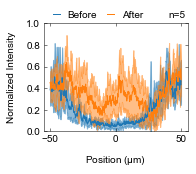

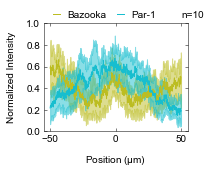

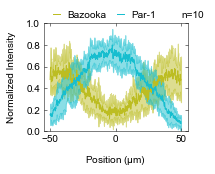

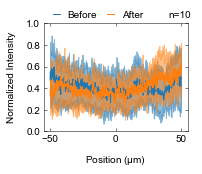

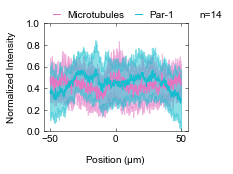

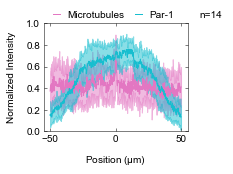

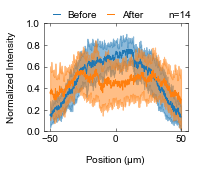

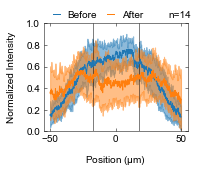

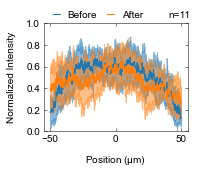

In [6]:
## Plotting
#COLOR = 'white' 
COLOR = 'black'
plot_size="small"
#plot_size="big"


#error = sem
error = np.std
#error = False


csv_files = [f for f in listdir('results//') if f.endswith("csv")]
txt_files = [f for f in listdir('results//') if f.endswith("txt")]
for file in csv_files:
    if 'after' in file:
        title = 'After ablation'
        if 'par1_baz' in file:
            label_first = 'Bazooka'
            label_second = 'Par-1'
            if COLOR=="black":
                col_first = sns.color_palette()[-2]
                col_second = sns.color_palette()[-1]
            else: 
                col_first = sns.color_palette("tab10")[-2]
                col_second = sns.color_palette("tab10")[-1]
        elif 'par1_jup' in file:
            label_first = 'Microtubules'
            label_second = 'Par-1'
            if COLOR=="black":
                col_first = sns.color_palette()[-4] 
                col_second = sns.color_palette()[-1]    
            else:
                col_first = sns.color_palette("tab10")[-4] 
                col_second = sns.color_palette("tab10")[-1]       
            
    elif 'before' in file: title = 'Before ablation'
    else:
        title= file[:-4]
        label_first = 'Before'
        label_second = 'After'
        #col_first = 'magenta'
        #col_second = 'lime'
        #col_first = sns.color_palette("tab10")[0]
        #col_second = sns.color_palette("tab10")[1]
        if COLOR == "black":
            col_first = sns.color_palette()[0]
            col_second = sns.color_palette()[1]
        else:
            col_first = sns.color_palette("tab10")[0]
            col_second = sns.color_palette("tab10")[1]

    title= file[:-4]

    

    #create figure
    fig, ax = create_fig(COLOR=COLOR, plot_size=plot_size, xlabel=r'Position ($\mathregular{\mu}$m)', ylabel='Normalized Intensity', square_fig=False)


    # Load data
    df = pd.read_csv('results//' + file)
    profile_first = df.iloc[:,:int(-df.shape[1]/2)]
    profile_second = df.iloc[:,int(-df.shape[1]/2):]
    x_axis = np.arange(-len(df)/2, len(df)/2, 1)*px_size

    if not error:
        for colname in profile_first:
            ax.plot(x_axis, profile_first[colname], linewidth=plt.rcParams['axes.linewidth']/2, color=col_first, alpha=0.5)

        for colname in profile_second:
            ax.plot(x_axis, profile_second[colname], linewidth=plt.rcParams['axes.linewidth']/2, color=col_second, alpha=0.5)


    mean_first = profile_first.apply(lambda row : np.mean(row), axis = 1)
    ax.plot(x_axis, mean_first, linewidth=plt.rcParams['axes.linewidth']*2, color=col_first, label=label_first)

    mean_second = profile_second.apply(lambda row : np.mean(row), axis = 1)
    ax.plot(x_axis, mean_second, linewidth=plt.rcParams['axes.linewidth']*2, color=col_second, label=label_second)

    handles = ax.get_legend_handles_labels()[0]
    num = len(profile_second.columns)

    patch_sample_size = mpatches.Patch(color='white', label='n='+str(num))
   

    handles.append(patch_sample_size)
    if COLOR == "black": legend = ax.legend(handles=handles,bbox_to_anchor=(0, 1.2), loc='upper left', prop={'size': plt.rcParams['font.size']}, framealpha=0, ncol=len(handles), columnspacing=1, handlelength=0.7)
    plt.ylim(0,1)

    if error:
        error_first = profile_first.apply(lambda row : error(row), axis = 1)
        error_second = profile_second.apply(lambda row : error(row), axis = 1)
        ax.fill_between(x_axis, mean_first-error_first, mean_first+error_first, color=col_first, alpha=0.5)
        ax.fill_between(x_axis, mean_second-error_second, mean_second+error_second, color=col_second, alpha=0.5)
    #ax.text(35, 1.2, 'n='+str(num), size=plt.rcParams['font.size'])

    txt_file = file.replace("csv", "txt")
    if txt_file in txt_files:
        f = open(f"results/{txt_file}", "r")
        ablation_width = float(f.read())
        f.close()
        ax.vlines(ablation_width/2, 0, 1, color=COLOR, linewidth = plt.rcParams['axes.linewidth'])
        ax.vlines(-ablation_width/2, 0, 1, color=COLOR, linewidth = plt.rcParams['axes.linewidth'])
    #plt.title(title)


    fig.savefig(f'{title}_{COLOR}_{plot_size}_{str(error)[10:13]}.pdf', dpi=300, transparent=True, bbox_inches='tight')
    fig.savefig(f'{title}_{COLOR}_{plot_size}_{str(error)[10:13]}.png', dpi=300, transparent=True, bbox_inches='tight')